# FORECASTING DE VENTAS MOTOS

In [1]:
%pip install pandas seaborn matplotlib pmdarima statsmodels scikit-learn skforecast tensorflow keras


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show tensorflow


Name: tensorflowNote: you may need to restart the kernel to use updated packages.

Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\edwin luna\appdata\roaming\python\python39\site-packages
Requires: tensorflow-intel
Required-by: 


# IMPORTANDO LIBRERIAS

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
import re
import warnings
import matplotlib.dates as mdates
import numpy as np
from io import StringIO
import contextlib
from sklearn import metrics
import plotly.express as px
from sklearn.model_selection import ParameterGrid

#LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras import regularizers
from keras.layers import Dropout
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# IMPORTAMOS LOS DATOS

In [4]:
# Ignora el aviso al leer el archivo
datos = pd.read_csv('ventas_africa_twin_2003_2023.csv', low_memory=False)

In [5]:
datos.head()

ref_fecha  ref_doc_venta_neta
0  2003-01-31        70000.000000
1  2003-02-28        70510.000000
2  2003-03-31        75436.443609
3  2003-04-30        92570.547448
4  2003-05-31        70312.400574

In [6]:
datos['ref_fecha'] = pd.to_datetime(datos['ref_fecha'], format='%Y-%m-%d')
datos = datos.set_index('ref_fecha')
datos = datos.asfreq('ME')
display(datos.head(4))

ref_doc_venta_neta
ref_fecha                     
2003-01-31        70000.000000
2003-02-28        70510.000000
2003-03-31        75436.443609
2003-04-30        92570.547448

In [7]:
ventas_mensuales = datos.copy()

FUNCION PARA EVALUAR

In [8]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [9]:
# Verificar valores nulos en la serie
print("Valores nulos en la serie original:")
print(datos.isnull().sum())

# Verificar si hay infinitos
print("\nValores infinitos en la serie original:")
print(np.isinf(datos).sum())


Valores nulos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Valores infinitos en la serie original:
ref_doc_venta_neta    0
dtype: int64


In [10]:
import pandas as pd
import numpy as np

# Supongamos que 'datos' es tu DataFrame original
# Verificar valores nulos en la serie
print("Valores nulos en la serie original:")
print(datos.isnull().sum())

# Muestra las filas con valores nulos en ref_doc_venta_neta
nulos = datos[datos['ref_doc_venta_neta'].isnull()]
print("\nFilas con valores nulos en 'ref_doc_venta_neta':")
print(nulos)

# Verificar si hay infinitos
print("\nValores infinitos en la serie original:")
print(np.isinf(datos).sum())

# Muestra las filas con valores infinitos en ref_doc_venta_neta
infinitos = datos[np.isinf(datos['ref_doc_venta_neta'])]
print("\nFilas con valores infinitos en 'ref_doc_venta_neta':")
print(infinitos)



Valores nulos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Filas con valores nulos en 'ref_doc_venta_neta':
Empty DataFrame
Columns: [ref_doc_venta_neta]
Index: []

Valores infinitos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Filas con valores infinitos en 'ref_doc_venta_neta':
Empty DataFrame
Columns: [ref_doc_venta_neta]
Index: []


# ESTACIONARIEDAD

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -0.039104977866485584, p-value: 0.9551761571468845
KPSS Statistic: 2.3720950270894785, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -9.740784881211981, p-value: 8.507096710828062e-17
KPSS Statistic: 0.0069181342035781876, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -11.271231168476993, p-value: 1.5350715613680363e-20
KPSS Statistic: 0.016064260631838446, p-value: 0.1


<Axes: title={'center': 'Diferenciación orden 2'}, xlabel='ref_fecha'>

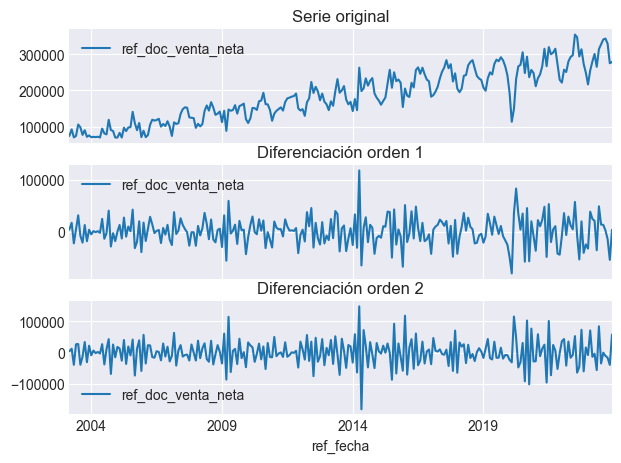

In [11]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2')


 ADF
 Hipótesis nula ( HO ): La serie tiene una raíz unitaria, no es estacionaria.
 Hipótesis alternativa ( HA ): La serie no tiene raíz unitaria, es estacionaria.

KPSS
 Hipótesis nula ( HO ): La serie es estacionaria.
 Hipótesis alternativa ( HA ): La serie no es estacionaria.

 En base a las Pruebas de Dickey-Fuller aumentada y Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
 se comprueba que la serie original no es estacionaria


# ANÁLISIS DE AUTOCORRELACIÓN

Text(0.5, 1.0, 'Autocorrelación serie diferenciada (order=1)')

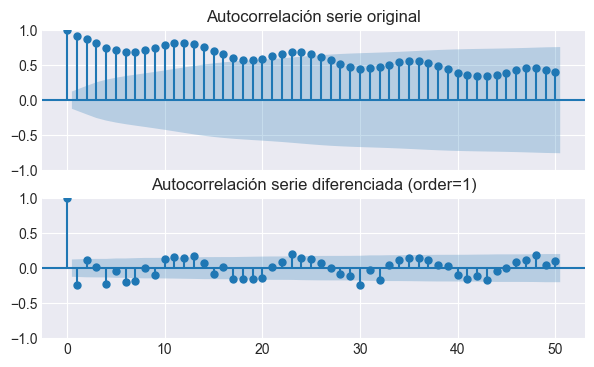

In [12]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)')


 La ACF presenta un patron sinusoidal por lo que se sugiere la presencia de estacionalidad (12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


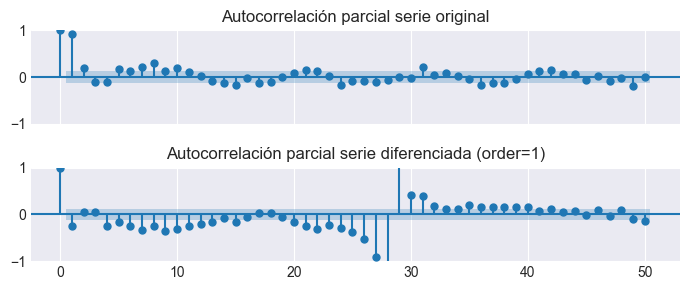

In [13]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación parcial serie diferenciada (order=1)');
plt.tight_layout()

## DESCOMPOSICIÓN DE SERIES TEMPORALES

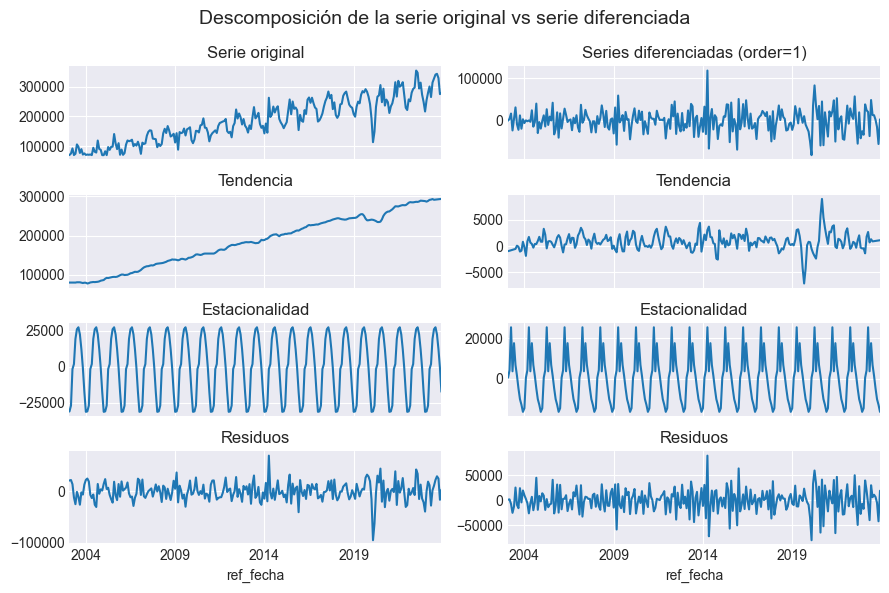

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie original y la serie diferenciada
# ==============================================================================

# Asegúrate de definir correctamente el periodo de la estacionalidad (ejemplo: 12 si es anual)
periodo = 12  # Cambia esto si la frecuencia de tus datos es diferente

# Descomponer la serie original
res_decompose = seasonal_decompose(datos, model='additive', period=periodo, extrapolate_trend='freq')

# Descomponer la serie diferenciada
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', period=periodo, extrapolate_trend='freq')

# Crear subplots para visualizar las descomposiciones
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

# Serie original
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')

# Serie diferenciada (order=1)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')

# Título general y ajuste del diseño
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout()
plt.show()


El patron recurrente cada 12 meses sugiere una estacionalidad anual confirmando lo observado en el gráfico ACF ya que se observan picos significativos en los lags correspondientes a los intervalos de 12 meses, confirmando la idea de
patrones recurrentes


In [15]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -7.523292838134438, p-value: 3.7413969934482236e-11
KPSS Statistic: 0.012404313773272432, p-value: 0.1


1. Prueba ADF (Augmented Dickey-Fuller):
Hipótesis nula (H0): La serie tiene una raíz unitaria, es decir, no es estacionaria.
Hipótesis alternativa (H1): La serie es estacionaria.
Interpretación:
ADF Statistic: -6.35
p-value: 2.61e-08 (muy bajo)
Dado que el valor p es mucho menor que el nivel de significancia comúnmente usado (como 0.05), rechazas la hipótesis nula. Esto significa que, según la prueba ADF, la serie diferenciada (combinación de diferenciación de orden 1 y diferenciación estacional) es estacionaria.

2. Prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin):
Hipótesis nula (H0): La serie es estacionaria.
Hipótesis alternativa (H1): La serie tiene una tendencia o no es estacionaria.
Interpretación:
KPSS Statistic: 0.030
p-value: 0.1
Aquí el valor p es mayor que 0.05, por lo que no rechazas la hipótesis nula.

Según la prueba KPSS, la serie es estacionaria.Con base en los resultados del análisis exploratorio, emplear una combinación de diferenciación de primer orden y diferenciación estacional podría ser el método más adecuado. La diferenciación de primer orden es útil para captar las transiciones entre observaciones y destacar las fluctuaciones a corto plazo. A su vez, la diferenciación estacional, que abarca un período de 12 meses y refleja el cambio anual, permite capturar los patrones cíclicos presentes en los datos. Esta estrategia facilita alcanzar la estacionariedad requerida para el posterior modelado ARIMA.

# SEPARAMOS LOS DATOS EN TRAIN Y TEST

Fechas train : 2003-01-31 00:00:00 --- 2017-09-30 00:00:00  (n=177)
Fechas test  : 2017-10-31 00:00:00 --- 2023-12-31 00:00:00  (n=75)


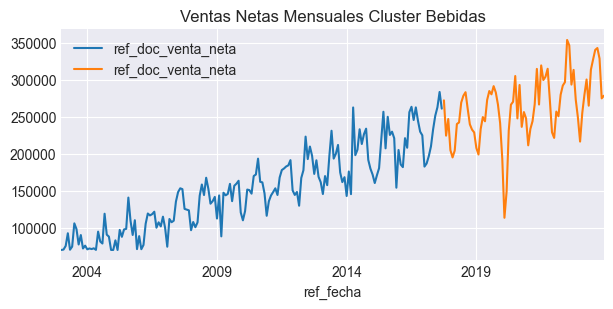

In [16]:
# Calcular la fecha de corte para dividir entre entrenamiento y prueba (80-20 split)
fin_train = datos.index[int(len(datos) * 0.7)]

# Dividir los datos en conjunto de entrenamiento y prueba
datos_train = datos.loc[datos.index <= fin_train]
datos_test = datos.loc[datos.index > fin_train]
test=datos_test.copy()
train=datos_train.copy()

# Imprimir la longitud de los conjuntos de entrenamiento y prueba
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Ventas Netas Mensuales Cluster Bebidas')
ax.legend()
plt.show()


# MODELO ARIMA-SARIMAX

## STATSMODELS

In [17]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 ref_doc_venta_neta   No. Observations:                  177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1869.187
Date:                            Tue, 01 Oct 2024   AIC                           3748.373
Time:                                    22:30:46   BIC                           3763.872
Sample:                                01-31-2003   HQIC                          3754.665
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0614      0.240      0.256      0.798      -0.409       0.532
ma.L1         -0.7822      0.148     -5.280      0.000      -1.073      -0.492
ar.S.L12      -0.2663      0.196     -1.357      0.175      -0.651       0.118
ma.S.L12      -0.6497      0.195     -3.327      0.001      -1.032      -0.267
sigma2      7.493e+08    7.6e-11   9.85e+18      0.000    7.49e+08    7.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                27.65
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.28e+35. Standard errors may be unstable.
"""

In [18]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels)

2017-10-31    254139.504505
2017-11-30    241036.074359
2017-12-31    211014.655236
2018-01-31    217553.788287
2018-02-28    213531.042550
                  ...      
2023-08-31    346302.835067
2023-09-30    341527.621263
2023-10-31    332507.751647
2023-11-30    319090.001642
2023-12-31    294342.948818
Freq: ME, Name: predicciones_statsmodels, Length: 75, dtype: float64

In [19]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_statsmodels)

Evaluation metric results:-
MSE is : 881930634.4967109
MAE is : 21096.453438317585
RMSE is : 29697.31695787872
MAPE is : 9.484690890521959
R2 is : 0.5336613979685891



## Modelo SARIMAX con skforecast.Sarimax 

In [20]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()
warnings.filterwarnings("default")

In [21]:
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(datos_test))
display(predicciones_skforecast.head(4))

pred
2017-10-31  254139.504505
2017-11-30  241036.074359
2017-12-31  211014.655236
2018-01-31  217553.788287

In [22]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_skforecast)

Evaluation metric results:-
MSE is : 881930634.4967109
MAE is : 21096.453438317585
RMSE is : 29697.31695787872
MAPE is : 19.552710769219907
R2 is : 0.5336613979685891



## PDMARIMA

In [23]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1870.545
Date:                            Tue, 01 Oct 2024   AIC                           3753.091
Time:                                    22:30:47   BIC                           3771.690
Sample:                                01-31-2003   HQIC                          3760.641
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    327.8038    544.600      0.602      0.547    -739.593    1395.201
ar.L1         -0.0672      0.231     -0.291      0.771      -0.519       0.385
ma.L1         -0.6539      0.184     -3.560      0.000      -1.014      -0.294
ar.S.L12      -0.2699      0.199     -1.360      0.174      -0.659       0.119
ma.S.L12      -0.6168      0.194     -3.174      0.002      -0.998      -0.236
sigma2      7.492e+08      0.000   4.24e+12      0.000    7.49e+08    7.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                27.07
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.45
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+29. Standard errors may be unstable.
"""

In [24]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

2017-10-31    259674.738996
2017-11-30    246476.835076
2017-12-31    216795.252542
2018-01-31    224204.895683
Freq: ME, Name: predicciones_pdmarima, dtype: float64

In [25]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_pdmarima)

Evaluation metric results:-
MSE is : 5952882225.831923
MAE is : 65971.18867683577
RMSE is : 77154.92353590873
MAPE is : 26.299437600091725
R2 is : -2.1477064824222807



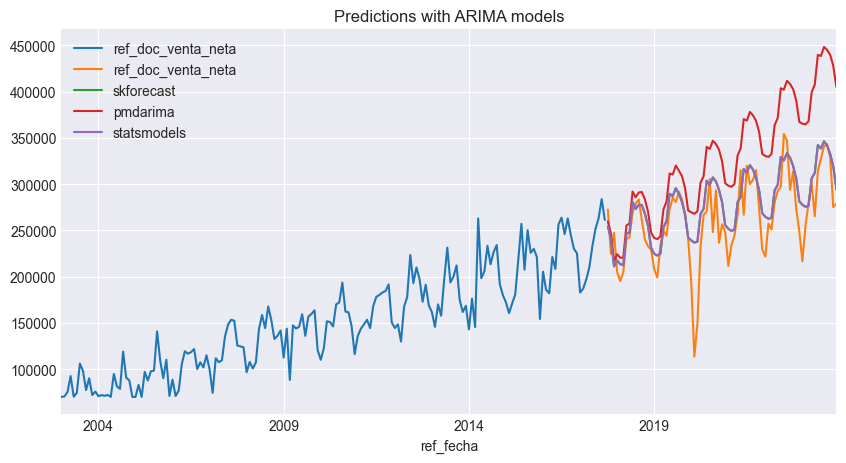

In [26]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
ax.set_title('Predictions with ARIMA models')
ax.legend()

## FORECASTERSARIMAX

In [27]:
datos_train = datos_train['ref_doc_venta_neta']

In [28]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=datos_train, suppress_warnings=True)

# Predicción
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head(4)

2017-10-31    254139.504505
2017-11-30    241036.074359
2017-12-31    211014.655236
2018-01-31    217553.788287
Freq: ME, Name: pred, dtype: float64

In [29]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 881930634.4967109
MAE is : 21096.453438317585
RMSE is : 29697.31695787872
MAPE is : 9.484690890521959
R2 is : 0.5336613979685891



## BACKTESTING

In [30]:
datos = datos['ref_doc_venta_neta']

In [31]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=500
                            )
             )

metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = datos,
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )

print(f"Metrica (mean absolute error): {metrica}")
display(predicciones.head(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 177
Number of observations used for backtesting: 75
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2003-01-31 00:00:00 -- 2017-09-30 00:00:00  (n=177)
    Validation: 2017-10-31 00:00:00 -- 2018-09-30 00:00:00  (n=12)
Fold: 1
    Training:   2003-01-31 00:00:00 -- 2018-09-30 00:00:00  (n=189)
    Validation: 2018-10-31 00:00:00 -- 2019-09-30 00:00:00  (n=12)
Fold: 2
    Training:   2003-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=201)
    Validation: 2019-10-31 00:00:00 -- 2020-09-30 00:00:00  (n=12)
Fold: 3
    Training:   2003-01-31 00:00:00 -- 2020-09-30 00:00:00  (n=213)
    Validation: 2020-10-31 00:00:00 -- 2021-09-30 00:00:00  (n=12)
Fold: 4
    Training:   2003-01-31 00:00:00

  0%|          | 0/7 [00:00<?, ?it/s]

Metrica (mean absolute error):    mean_absolute_error
0         19495.259919


pred
2017-10-31  254139.504505
2017-11-30  241036.074359
2017-12-31  211014.655236
2018-01-31  217553.788287

In [32]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 718356522.214862
MAE is : 19495.25991900565
RMSE is : 26802.17383375576
MAPE is : 18.21662513126085
R2 is : 0.6201545073655402



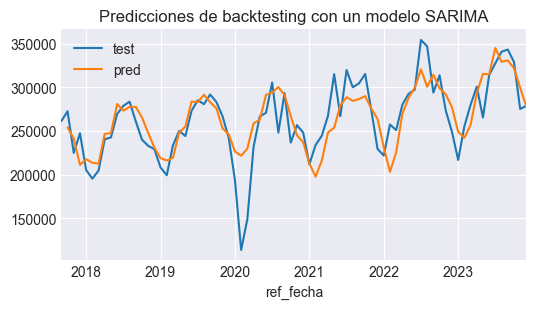

In [33]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()

## BUSQUEDA DE HIPERPARAMETROS p,d,q

Fechas entrenamiento : 2003-01-31 00:00:00 --- 2010-01-31 00:00:00  (n=85)
Fechas validacion    : 2010-02-28 00:00:00 --- 2018-01-31 00:00:00  (n=96)
Fechas test          : 2018-02-28 00:00:00 --- 2023-12-31 00:00:00  (n=71)


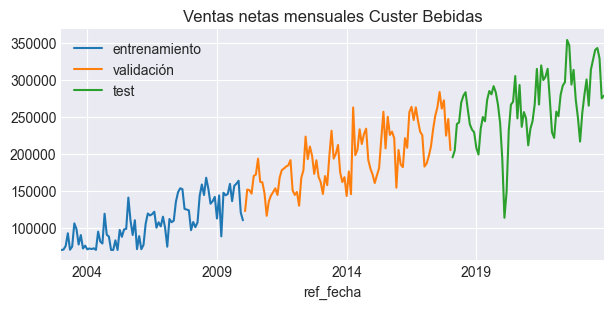

In [34]:
# Definir las fechas de corte
fin_train = '2010-02-01 23:59:59'
fin_val = '2018-02-01 23:59:59'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:fin_val].plot(ax=ax, label='validación')
datos.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Ventas netas mensuales Custer Bebidas')
ax.legend();

In [35]:
# Grid search basado en backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(1, 0, 1), (1, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1), (2, 1, 0), (0, 1, 2)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12), (0, 1, 1, 12), (1, 1, 0, 12), (1, 0, 1, 12)],
    'trend': [None, 'n', 'c']
}

resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = datos.loc[:fin_val],
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(datos_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )

resultados_grid.head(5)

Number of models compared: 180.


params grid:   0%|          | 0/180 [00:00<?, ?it/s]

params  mean_absolute_error  \
95   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...          9454.482572   
93   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...          9581.650414   
94   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...          9581.650414   
41   {'order': (0, 0, 1), 'seasonal_order': (0, 1, ...         12471.674291   
113  {'order': (1, 1, 1), 'seasonal_order': (0, 1, ...         12720.988406   

         order seasonal_order trend  
95   (1, 1, 0)  (0, 1, 0, 12)     c  
93   (1, 1, 0)  (0, 1, 0, 12)  None  
94   (1, 1, 0)  (0, 1, 0, 12)     n  
41   (0, 0, 1)  (0, 1, 0, 12)     c  
113  (1, 1, 1)  (0, 1, 0, 12)     c

In [36]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = datos.loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 4,
            max_q             = 4,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=4387.723, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4468.109, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4174.947, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4356.937, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4859.663, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4173.115, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4174.948, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=4176.947, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4151.913, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=4147.501, Time=0.25 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=4138.080, Time=0.39 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=4138.096, Time=0.61 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=4144.116, Time=0.32 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4171.857, Time=0.30 sec
 ARIMA(3,0,0)(2,0,0

In [37]:
# Predicciones de backtesting con el mejor modelo según el grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(4, 0, 4), seasonal_order=(1, 0, 1, 12), maxiter=500),
             )

metrica_m1, predicciones_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Predicciones de backtesting con el mejor modelo según auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(4, 0, 4), seasonal_order=(2, 0, 1, 12), maxiter=500),
             )

metrica_m2, predicciones_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search :    mean_absolute_error
0         22223.781287
Metric (mean_absolute_error) del modelo auto arima   :    mean_absolute_error
0         20885.076184


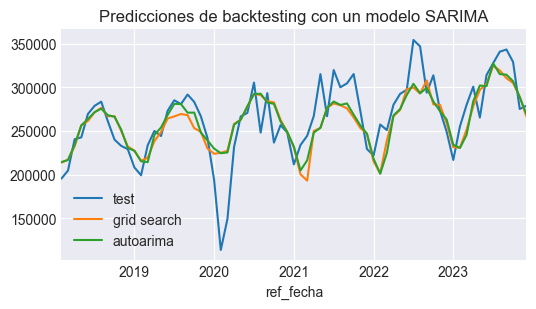

In [38]:
# Comparación de métricas
# ==============================================================================
print(f"Metrica (mean absolute error) del modelo grid search : {metrica_m1}")
print(f"Metric (mean_absolute_error) del modelo auto arima   : {metrica_m2}")

fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_val:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
predicciones_m1.plot(ax=ax)
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()

# PROYECCION CON MODELO HOLT WINTERS ADITIVO

In [39]:
# Definir el modelo Holt-Winters
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal='add', seasonal_periods=12)  

# Ajustar el modelo con los datos de entrenamiento
resultado = modelo.fit()

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index, 'Venta_Real': datos_test['ref_doc_venta_neta'], 'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha     Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  272508.190440       242517.053065
2017-11-30 2017-11-30  224719.390529       234919.846860
2017-12-31 2017-12-31  247284.609212       216308.345550
2018-01-31 2018-01-31  205074.253244       211655.103670
2018-02-28 2018-02-28  195250.206375       212067.279553
...               ...            ...                 ...
2023-08-31 2023-08-31  340801.655137       261632.291547
2023-09-30 2023-09-30  343326.435118       253523.991359
2023-10-31 2023-10-31  329066.757537       242517.053065
2023-11-30 2023-11-30  275178.374151       234919.846860
2023-12-31 2023-12-31  278767.929206       216308.345550

[75 rows x 3 columns]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


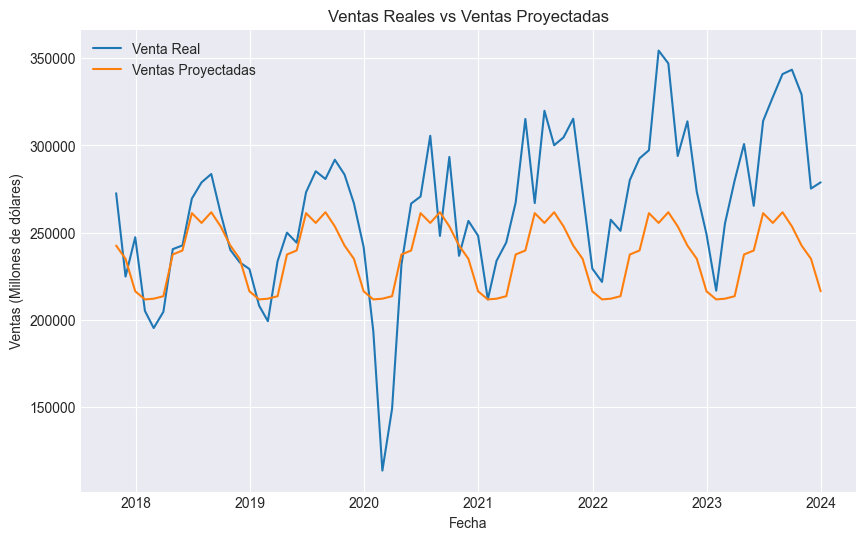

In [40]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [41]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 1821708591.0193908
MAE is : 33906.63361289646
RMSE is : 42681.47831342526
MAPE is : 12.818189074065895
R2 is : 0.03673485825855827



# PROYECCION CON MODELO HOLT WINTERS MULTIPLICATIVO

In [42]:
# Definir el modelo Holt-Winters
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal='mul', seasonal_periods=12)  

# Ajustar el modelo con los datos de entrenamiento
resultado = modelo.fit()

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index, 'Venta_Real': datos_test['ref_doc_venta_neta'], 'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha     Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  272508.190440       240373.920811
2017-11-30 2017-11-30  224719.390529       232836.272929
2017-12-31 2017-12-31  247284.609212       205006.450737
2018-01-31 2018-01-31  205074.253244       201327.422198
2018-02-28 2018-02-28  195250.206375       185597.673586
...               ...            ...                 ...
2023-08-31 2023-08-31  340801.655137       278529.229059
2023-09-30 2023-09-30  343326.435118       260016.213866
2023-10-31 2023-10-31  329066.757537       240373.920811
2023-11-30 2023-11-30  275178.374151       232836.272929
2023-12-31 2023-12-31  278767.929206       205006.450737

[75 rows x 3 columns]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


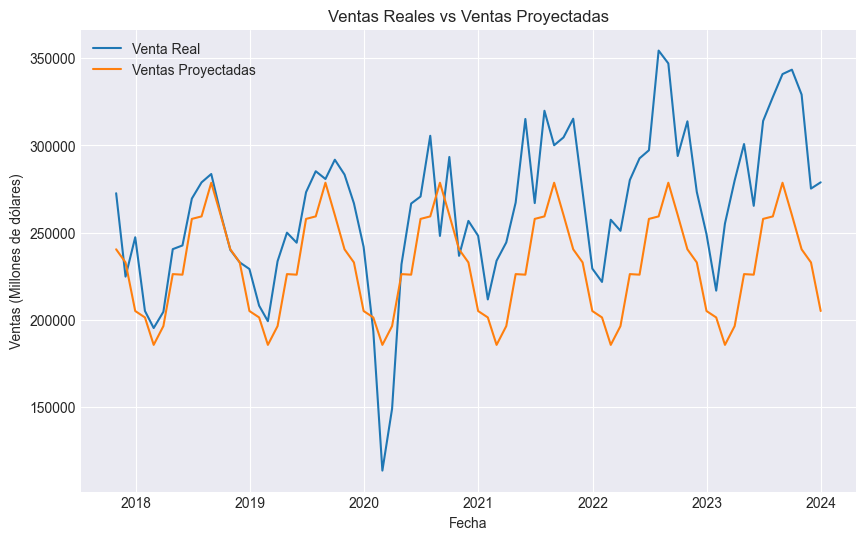

In [43]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [44]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 2025955016.0095873
MAE is : 37107.49507981416
RMSE is : 45010.6100381853
MAPE is : 13.938777776684356
R2 is : -0.07126455640538132



# BUSQUEDA DE MEJORES HIPERPARAMETROS HOLT WINTERS

In [45]:
# Definir los rangos de valores para los hiperparámetros
param_grid = {
    'trend': ['add', 'mul'],  
    'seasonal': ['add', 'mul'],  
    'seasonal_periods': [12],  
    'smoothing_level': np.linspace(0.1, 1.0, 10),  # Rango de valores para alfa
    'smoothing_trend': np.linspace(0.1, 1.0, 10),  # Rango de valores para beta
    'smoothing_seasonal': np.linspace(0.1, 1.0, 10)  # Rango de valores para gamma
}

# Generar todas las combinaciones de hiperparámetros
param_combinations = list(ParameterGrid(param_grid))

# Función para calcular el MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inicializar variables para almacenar los mejores hiperparámetros y el mejor modelo
best_score = float('inf')
best_params = None
best_model = None

# Iterar sobre todas las combinaciones de hiperparámetros
for params in param_combinations:
    # Definir y ajustar el modelo Holt-Winters con los hiperparámetros actuales
    modelo = ExponentialSmoothing(train['ref_doc_venta_neta'],
                                  trend=params['trend'],
                                  seasonal=params['seasonal'],
                                  seasonal_periods=params['seasonal_periods'],
                                  initialization_method="estimated")
    resultado = modelo.fit(smoothing_level=params['smoothing_level'],
                           smoothing_trend=params['smoothing_trend'],
                           smoothing_seasonal=params['smoothing_seasonal'])

    # Realizar predicciones en el conjunto de prueba
    predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

    # Calcular el MAPE
    mape = calculate_mape(datos_test['ref_doc_venta_neta'], predicciones)

    # Actualizar los mejores hiperparámetros y el mejor modelo si se encuentra un modelo con un mejor rendimiento
    if mape < best_score:
        best_score = mape
        best_params = params
        best_model = resultado

# Imprimir los mejores hiperparámetros y el mejor modelo
print("Mejores hiperparámetros:", best_params)
print("Error Porcentual Absoluto Medio (MAPE) en conjunto de prueba:", best_score)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid val

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid val

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid val

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid val

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid value encountered in divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + (
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarn

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid value encountered in divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + (
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1372: RuntimeWarn

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trende

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid value encountered in divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + (
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1367: RuntimeWarn

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], damp

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid value encountered in divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + (
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1367: RuntimeWarning: invalid value encountered in double_scalars
  betac * dampen(b[i - 1], phi)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1372: RuntimeWarning: invalid value encountered in double_scalars
  + (gammac * s[i - 1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\mode

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid value encountered in divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + (
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: R

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid value encountered in divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + (
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1372: RuntimeWarn

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: invalid value encountered in double_scalars
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning:

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: invalid value encountered in double_scalars
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:13

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1352: RuntimeWarning: overflow encountered in power
  b[nobs:] = dampen(b[nobs], phi_h)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1353: RuntimeWarning: overflow encountered in multiply
 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1352: RuntimeWarning: overflow encountered in power
  b[nobs:] = dampen(b[nobs], phi_h)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1353: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_

Mejores hiperparámetros: {'seasonal': 'add', 'seasonal_periods': 12, 'smoothing_level': 0.2, 'smoothing_seasonal': 0.6, 'smoothing_trend': 0.1, 'trend': 'add'}
Error Porcentual Absoluto Medio (MAPE) en conjunto de prueba: 7.156246607644991


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1338: RuntimeWarning: overflow encountered in multiply
  alphac * trended(lvls[i - 1], dampen(b[i - 1], phi))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1338: RuntimeWarning: invalid value encountered in double_scalars
  alphac * trended(lvls[i - 1], dampen(b[i - 1], phi))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1344: RuntimeWarning: overflow encountered in multiply
  s[i + m - 1] = y_gamma[i - 1] / trended(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1337: RuntimeWarning: divide by zero encountered in double_scalars
  lvls[i] = y_alpha[i - 1] / s[i - 1] + (
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1353: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:

In [46]:
# Definir los hiperparámetros obtenidos
hiperparametros = {
    'seasonal': best_params['seasonal'],
    'seasonal_periods': best_params['seasonal_periods'],
    'smoothing_level': best_params['smoothing_level'],
    'smoothing_seasonal': best_params['smoothing_seasonal'],
    'smoothing_trend': best_params['smoothing_trend'],
    'trend': best_params['trend']
}


# Definir el modelo Holt-Winters sin pasar directamente los hiperparámetros al constructor
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal_periods=hiperparametros['seasonal_periods'], trend=hiperparametros['trend'], seasonal=hiperparametros['seasonal'])

# Ajustar el modelo con los datos de entrenamiento y los hiperparámetros obtenidos
resultado = modelo.fit(smoothing_level=hiperparametros['smoothing_level'], smoothing_trend=hiperparametros['smoothing_trend'], smoothing_seasonal=hiperparametros['smoothing_seasonal'])

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index,
                                'Venta_Real': datos_test['ref_doc_venta_neta'],
                                'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha     Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  272508.190440       252131.475604
2017-11-30 2017-11-30  224719.390529       235742.409042
2017-12-31 2017-12-31  247284.609212       213459.730404
2018-01-31 2018-01-31  205074.253244       194544.637033
2018-02-28 2018-02-28  195250.206375       195482.970653
...               ...            ...                 ...
2023-08-31 2023-08-31  340801.655137       335368.377047
2023-09-30 2023-09-30  343326.435118       324018.752750
2023-10-31 2023-10-31  329066.757537       310364.155554
2023-11-30 2023-11-30  275178.374151       293975.088992
2023-12-31 2023-12-31  278767.929206       271692.410354

[75 rows x 3 columns]


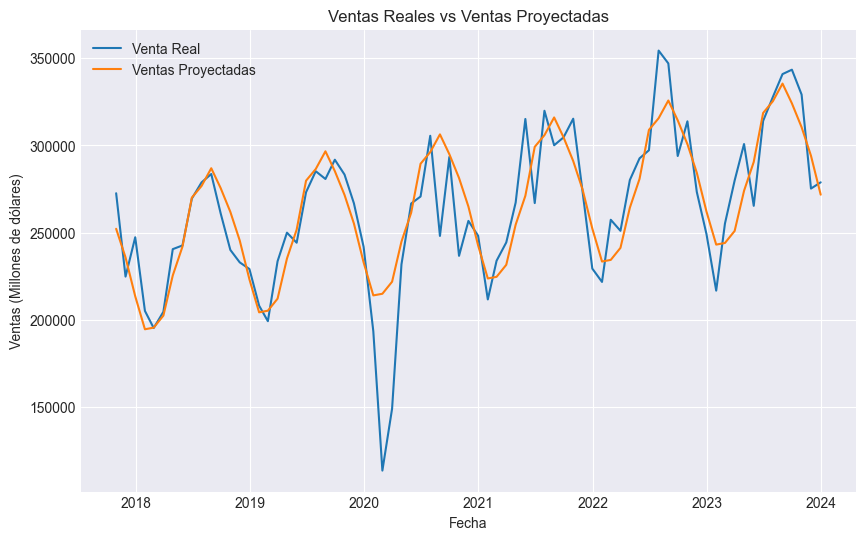

In [47]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [48]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 532250083.6793826
MAE is : 16367.418039160917
RMSE is : 23070.54580367319
MAPE is : 7.156246607644991
R2 is : 0.7185620385034143



# RED NEURONAL LSTM

## PRUEBA LSTM 1

In [49]:
scaler = MinMaxScaler()

In [50]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [51]:
scaled_test_data.shape

(75, 1)

In [52]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [53]:
generator

In [54]:


lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(200, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,801 (632.04 KB)

 Trainable params: 161,801 (632.04 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
lstm_model.fit(generator, epochs=400)


Epoch 1/400
 15/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1207

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x23e1e6330a0>


165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0489
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0197
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0141
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0143
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0192
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0129
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0129
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0122
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0132
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0112
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0099
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0081
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0042
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0039
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0054
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0043
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0022
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7389e-04
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2619e-04
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2899e-04
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0787e-04
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2717e-04
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8684e-04
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0320e-04
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1016e-04
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5335e-04
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.002

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037
Epoch 392/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9073e-04
Epoch 393/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6094e-04
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.5482e-04
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4153e-04
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8878e-04
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3896e-04
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4669e-04
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2963e-04
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5033e-04


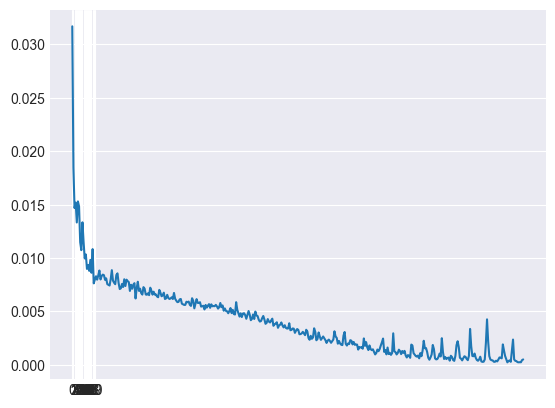

In [56]:
losses_lstm = lstm_model.history.history['loss']
#plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [57]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━

In [58]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [59]:
lstm_predictions

array([[271128.05248977],
       [256991.48495485],
       [235040.88679692],
       [197262.37419483],
       [205349.68622223],
       [206219.59570084],
       [208851.23406318],
       [238807.97937826],
       [252687.41436096],
       [288243.0062349 ],
       [282907.65235237],
       [294263.35440483],
       [289227.28323562],
       [282732.37294035],
       [261979.09682181],
       [254268.61258792],
       [215653.66081961],
       [214822.74055867],
       [222321.25039601],
       [227806.31573678],
       [253514.42167983],
       [264037.21513596],
       [298231.51102957],
       [303498.91737389],
       [301959.07907218],
       [303858.70411346],
       [293855.23582041],
       [276307.44950163],
       [254238.17576157],
       [239318.4844895 ],
       [217945.39579627],
       [229945.20380325],
       [234068.29763948],
       [263320.29277067],
       [265701.75775465],
       [294757.68517242],
       [311774.01238394],
       [310895.98386915],
       [3130

In [60]:
datos_test['LSTM_Predictions'] = lstm_predictions

In [61]:
datos_test

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       272508.190440     271128.052490
2017-11-30       224719.390529     256991.484955
2017-12-31       247284.609212     235040.886797
2018-01-31       205074.253244     197262.374195
2018-02-28       195250.206375     205349.686222
...                        ...               ...
2023-08-31       340801.655137     258697.718888
2023-09-30       343326.435118     232393.379989
2023-10-31       329066.757537     259499.515134
2023-11-30       275178.374151     252077.811124
2023-12-31       278767.929206     285752.845583

[75 rows x 2 columns]

In [62]:
ai=datos_test[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=datos_test.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [63]:
evaluacion_metrica(datos_test["ref_doc_venta_neta"],datos_test["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 2856892859.3112416
MAE is : 42487.05560533239
RMSE is : 53449.9098157447
MAPE is : 17.2884837267457
R2 is : -0.510639692117071



In [64]:
datos_test = datos_test.drop(columns=['LSTM_Predictions'])

## PRUEBA LSTM 2

In [65]:
scaler = MinMaxScaler()

In [66]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [67]:
scaled_test_data.shape

(75, 1)

In [68]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [69]:
generator

Epoch 1/400
 31/165 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2038

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x23e16528400>



165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6847
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0543
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0339
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0281
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0344
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0255
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0249
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0220
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0205
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0239
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0222
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0237
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0217
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0141
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0179
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0204
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0204
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0180
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0205
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0181
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0196
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0197
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0180
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0143
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0169
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0153
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0187
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0182
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0213
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0189
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0157
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0158
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0160
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0193
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0150
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0157
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0227
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0137
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0127
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0184
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0129
Epoch 329/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0171
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0154
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0137
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0144
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0160
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133


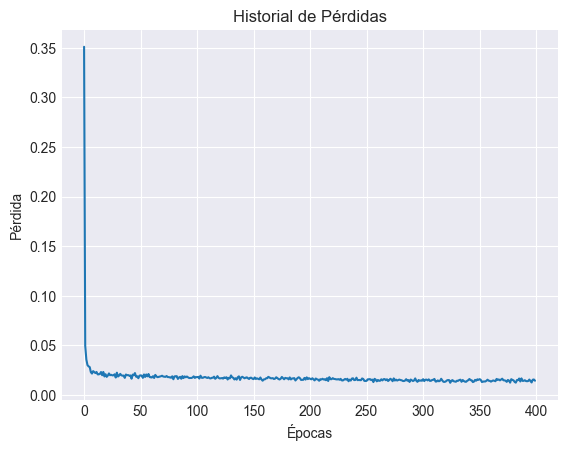

In [70]:
regularization = regularizers.l2(0.01)  

# Define el modelo LSTM
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(100, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(50, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [71]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

In [72]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [73]:
lstm_predictions

array([[236598.78581174],
       [228992.29406787],
       [220345.78820367],
       [200523.84328324],
       [207978.24011556],
       [218219.41645356],
       [228756.77829014],
       [239076.200724  ],
       [245412.03144238],
       [248943.21312807],
       [250730.11484766],
       [242689.96205705],
       [234054.18810566],
       [229419.56949902],
       [223636.049918  ],
       [217469.40614808],
       [223567.60529595],
       [229805.16636143],
       [235007.0850953 ],
       [238948.29722635],
       [241008.25092701],
       [241712.13440061],
       [240923.47901243],
       [237384.48418832],
       [233810.70624063],
       [231314.312922  ],
       [228858.88441068],
       [228005.31497033],
       [231416.78866899],
       [234367.45289541],
       [236553.67863903],
       [237964.12219155],
       [238544.70337952],
       [238449.22504361],
       [237609.22981602],
       [235970.73948922],
       [234435.45141658],
       [233341.33163133],
       [2326

In [74]:
test_data1 = datos_test.copy()

In [75]:
test_data1['LSTM_Predictions'] = lstm_predictions

In [76]:
test_data1

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       272508.190440     236598.785812
2017-11-30       224719.390529     228992.294068
2017-12-31       247284.609212     220345.788204
2018-01-31       205074.253244     200523.843283
2018-02-28       195250.206375     207978.240116
...                        ...               ...
2023-08-31       340801.655137     236216.247927
2023-09-30       343326.435118     236088.573853
2023-10-31       329066.757537     236013.259277
2023-11-30       275178.374151     236007.855083
2023-12-31       278767.929206     236073.406422

[75 rows x 2 columns]

In [77]:
ai=test_data1[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data1.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [78]:
evaluacion_metrica(test_data1["ref_doc_venta_neta"],test_data1["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 2475091730.9048505
MAE is : 38660.34930688347
RMSE is : 49750.29377707081
MAPE is : 14.574575288171058
R2 is : -0.30875464865596247



## PRUEBA LSTM 3

In [79]:
scaler = MinMaxScaler()

In [80]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [81]:
scaled_test_data.shape

(75, 1)

In [82]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [83]:
generator

Epoch 1/400
 33/165 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2471

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x23e238fbfa0>



165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7090
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0596
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0380
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0293
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0274
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0273
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0260
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0283
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0232
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0219
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0228
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0193
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0188
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0200
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0199
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0182
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0209
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0192
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0168
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0191
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0198
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0165
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0195
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0200
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0209
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0192
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0166
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0190
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0202
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0160
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0244
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0179
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0184
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0171
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0198
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0171
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0133
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0170
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0188
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0181
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0219
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0179
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0155
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0163
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0187
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0203
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0200
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0201
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0160
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0136
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0146
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0158
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0163
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0162
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0161
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0188
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0150
Epoch 329/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0133
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0149


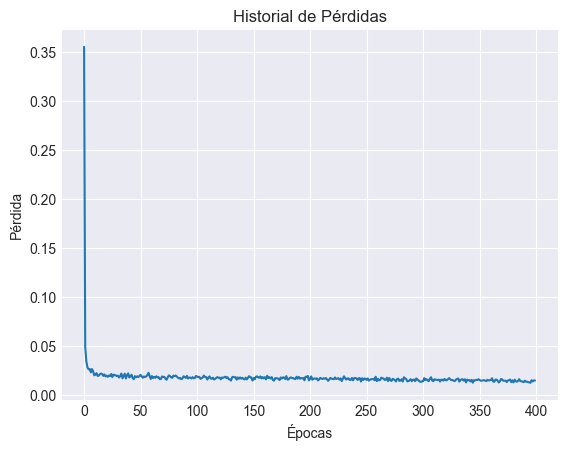

In [84]:
# Define la regularización L1 o L2 que deseas probar
regularization = regularizers.l2(0.01) 

# Define el modelo LSTM usando Input en lugar de input_shape
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(100, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(50, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [85]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [86]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [87]:
lstm_predictions

array([[222035.465421  ],
       [214036.26469197],
       [205373.5462469 ],
       [189784.02811765],
       [196002.72548841],
       [204995.4056422 ],
       [214891.12145203],
       [225176.66570983],
       [231847.54368707],
       [235516.41759848],
       [236740.49294546],
       [225752.98982075],
       [210781.33416802],
       [205212.5675548 ],
       [199473.4158936 ],
       [195384.99046928],
       [201080.1693286 ],
       [207415.50296314],
       [213188.6602578 ],
       [217782.98958132],
       [220203.11239373],
       [220626.85725499],
       [218473.22236772],
       [211807.264246  ],
       [204550.98719119],
       [201039.23001277],
       [198574.31867113],
       [198819.92907468],
       [203056.21782498],
       [207016.37012519],
       [210116.89875872],
       [212094.75715012],
       [212672.82742738],
       [211824.47099456],
       [209270.37771241],
       [205019.83922516],
       [201197.28993048],
       [199433.15210196],
       [1989

In [88]:
test_data2 = datos_test.copy()

In [89]:
test_data2['LSTM_Predictions'] = lstm_predictions

In [90]:
test_data2

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       272508.190440     222035.465421
2017-11-30       224719.390529     214036.264692
2017-12-31       247284.609212     205373.546247
2018-01-31       205074.253244     189784.028118
2018-02-28       195250.206375     196002.725488
...                        ...               ...
2023-08-31       340801.655137     199378.982708
2023-09-30       343326.435118     198597.133545
2023-10-31       329066.757537     198365.568947
2023-11-30       275178.374151     198673.480526
2023-12-31       278767.929206     199307.083991

[75 rows x 2 columns]

In [91]:
ai=test_data2[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data2.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [92]:
evaluacion_metrica(test_data2["ref_doc_venta_neta"],test_data2["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 5175673243.310345
MAE is : 61110.635346890376
RMSE is : 71942.15206198898
MAPE is : 22.268472997264194
R2 is : -1.7367415649804436



## PRUEBA LSTM 4

In [93]:
scaler = MinMaxScaler()

In [94]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [95]:
scaled_test_data.shape

(75, 1)

In [96]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [97]:
generator

In [98]:
batch_size=1
epochs = 600

In [119]:
# Define la función para crear el modelo LSTM
def create_lstm_model(units=100, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(n_input, n_features)))  
    model.add(LSTM(units=units, activation='relu'))  
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Define una clase de envoltura para el modelo de Keras
class KerasWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, units=100, optimizer='adam'):
        self.units = units
        self.optimizer = optimizer
        self.model = None

    def fit(self, X, y):
        self.model = create_lstm_model(units=self.units, optimizer=self.optimizer)
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Define los parámetros a buscar
param_grid = {
    'units': [50, 100, 200],
    'optimizer': ['adam', 'rmsprop']
}

# Define el esquema de validación cruzada KFold
kf = KFold(n_splits=5, shuffle=True)

# Envuelve el modelo en la clase KerasWrapper
keras_model_wrapper = KerasWrapper()

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV con KFold
grid_search = GridSearchCV(estimator=keras_model_wrapper, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(scaled_train_data, scaled_train_data)

# Muestra los resultados de la búsqueda de hiperparámetros
print("Mejor MSE: {:.4f}".format(-grid_result.best_score_))
print("Mejores Parámetros: ", grid_result.best_params_)


KeyboardInterrupt: 

Epoch 1/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0617
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0180
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0123
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6663e-04
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 251/400
165/165 ━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1359e-04
Epoch 315/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2940e-04
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9864e-04
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6277e-04
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7739e-04
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5581e-04
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.1084e-04
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.7826e-04
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4427e-04
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4926e-04
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 391/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 392/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6164e-04
Epoch 393/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1051e-04
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0475e-04
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2476e-04
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9280e-04
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5111e-04
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0410e-04
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8760e-04
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0272e-04


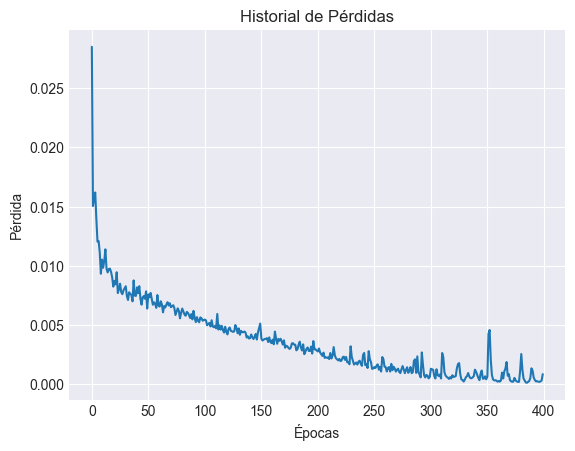

In [118]:
# Define los mejores parámetros obtenidos de la búsqueda de hiperparámetros
best_optimizer = 'adam'
best_units = 200

# Construye el modelo LSTM con los mejores parámetros
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(units=best_units, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=best_optimizer, loss='mse')

# Entrena el modelo con los datos de entrenamiento
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [101]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [102]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [103]:
lstm_predictions

array([[268139.80107705],
       [259409.73414354],
       [236812.047528  ],
       [226663.82586946],
       [213905.41692846],
       [209807.12630164],
       [231912.06262131],
       [245750.9534061 ],
       [266991.80505019],
       [286491.92004381],
       [269601.31680845],
       [292074.93639398],
       [274265.18688765],
       [269098.68856434],
       [261111.03547546],
       [246022.57786433],
       [240407.64618201],
       [248666.09525604],
       [251728.32294184],
       [270939.61947441],
       [285107.42681727],
       [277835.53623136],
       [306121.22585478],
       [278263.64013559],
       [288824.26294708],
       [278887.11073757],
       [270282.24520489],
       [271024.17471141],
       [271611.10327774],
       [269192.68839445],
       [285147.19352506],
       [290299.93919526],
       [290644.73694497],
       [307676.18060374],
       [282281.86202577],
       [307292.6612969 ],
       [285742.67448271],
       [289935.76792124],
       [2903

In [104]:
test_data3 = datos_test.copy()

In [105]:
test_data3['LSTM_Predictions'] = lstm_predictions

In [106]:
test_data3

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       272508.190440     268139.801077
2017-11-30       224719.390529     259409.734144
2017-12-31       247284.609212     236812.047528
2018-01-31       205074.253244     226663.825869
2018-02-28       195250.206375     213905.416928
...                        ...               ...
2023-08-31       340801.655137     341697.414844
2023-09-30       343326.435118     311778.040038
2023-10-31       329066.757537     336687.829322
2023-11-30       275178.374151     320429.848130
2023-12-31       278767.929206     341460.038188

[75 rows x 2 columns]

In [107]:
ai=test_data3[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data3.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [108]:
evaluacion_metrica(test_data3["ref_doc_venta_neta"],test_data3["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1976090792.7348628
MAE is : 33973.69306305395
RMSE is : 44453.242769621014
MAPE is : 15.042317719299476
R2 is : -0.04489784312459455



## PRUEBA LSTM 5

Epoch 1/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0673
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0526
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0289
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0277
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0206
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0206
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0233
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0231
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0221
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0251
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0238
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0221
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0198
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0215
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 4

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0158
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0152
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0196
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0201
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0185
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0162
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0182
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0180
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0198
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0167
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0151
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0201
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0186
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0184
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0190
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0176
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0176
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0165
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0155
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0205
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0133
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0166
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0149
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0143
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0145
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0155
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0149
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0160
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0165
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0128
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0134
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0143
Epoch 329/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0113
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135


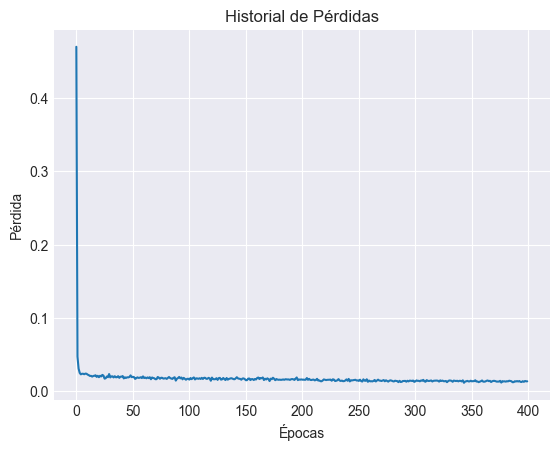

In [109]:
# Define la regularización L1 o L2 que deseas probar
regularization = regularizers.l2(0.01)  # Regularización L2 con un valor de 0.01

# Define el modelo LSTM usando Input en lugar de input_shape
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(200, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(100, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [110]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [111]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [112]:
lstm_predictions

array([[250997.71165215],
       [239034.10154585],
       [225951.23705567],
       [200375.53385637],
       [210168.08564926],
       [224335.53611141],
       [239961.17566691],
       [255967.65792392],
       [266388.85508909],
       [272489.90928265],
       [275870.51279981],
       [264341.27750166],
       [256410.2027512 ],
       [246605.26209935],
       [235329.34837726],
       [224880.53119421],
       [236587.7862384 ],
       [248842.73846221],
       [259669.12269168],
       [268295.9746253 ],
       [273155.00747041],
       [275081.22012465],
       [273928.59739429],
       [267398.52160325],
       [261604.486787  ],
       [254981.95340035],
       [248988.25657209],
       [247675.84050341],
       [256443.97896134],
       [264133.36899607],
       [270143.97942089],
       [274172.34691985],
       [276016.42602762],
       [276064.45197471],
       [274223.73774222],
       [270393.3370719 ],
       [266716.01273509],
       [263142.71912551],
       [2611

In [113]:
test_data4 = datos_test.copy()

In [114]:
test_data4['LSTM_Predictions'] = lstm_predictions

In [115]:
test_data4

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       272508.190440     250997.711652
2017-11-30       224719.390529     239034.101546
2017-12-31       247284.609212     225951.237056
2018-01-31       205074.253244     200375.533856
2018-02-28       195250.206375     210168.085649
...                        ...               ...
2023-08-31       340801.655137     277475.609289
2023-09-30       343326.435118     276932.768236
2023-10-31       329066.757537     276599.722058
2023-11-30       275178.374151     276602.092766
2023-12-31       278767.929206     277006.234679

[75 rows x 2 columns]

In [116]:
ai=test_data4[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data4.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [117]:
evaluacion_metrica(test_data4["ref_doc_venta_neta"],test_data4["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1307079472.812547
MAE is : 25986.068460339367
RMSE is : 36153.55408272535
MAPE is : 11.141780681459045
R2 is : 0.30885537903646787

